In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# Robust import setup using utility module
try:
    # Try importing the utility (works if run from analysis/ directory)
    from import_utils import quick_setup
    Simulation = quick_setup()
except ImportError:
    # Fallback: try direct import (works if run from project root)
    try:
        from src.simulation import Simulation
        print("✅ Direct import successful")
    except ImportError:
        # Last resort: manual path setup
        import sys
        import os
        current_dir = os.getcwd()
        
        # Look for src directory
        if os.path.exists('src'):
            # Run from project root
            sys.path.insert(0, current_dir)
        elif os.path.exists('../src'):
            # Run from subdirectory
            sys.path.insert(0, os.path.dirname(current_dir))
        else:
            raise ImportError("Cannot locate src/ directory. Please run from project root or analysis/ subdirectory.")
        
        from src.simulation import Simulation
        print("✅ Manual path setup successful")

# Define fitness functions
def neutral_fitness(population):
    """True neutral evolution: all individuals have equal fitness"""
    return np.ones(len(population.genomes))

def weak_selection(population):
    """Weak selection: fitness = 1 + s * (number of 1s)"""
    s = 0.05  # weak selection coefficient (increased for visibility)
    base_fitness = np.array([np.sum(g.sequence) for g in population.genomes])
    return 1.0 + s * base_fitness

print("✅ Setup complete. Fitness regimes defined:")
print("  • neutral_fitness() - True neutral (equal fitness)")
print("  • fitness_function=None - Additive selection")  
print("  • weak_selection() - Custom weak selection")


✅ Project root: /Users/niallHome/Documents/programming/SelectionAndSexualReproduction
✅ Found src/ at: /Users/niallHome/Documents/programming/SelectionAndSexualReproduction/src
✅ Successfully imported simulation modules
✅ Setup complete. Fitness regimes defined:
  • neutral_fitness() - True neutral (equal fitness)
  • fitness_function=None - Additive selection
  • weak_selection() - Custom weak selection


In [2]:
# Simulation parameters with consistent base seed for reproducible comparisons
base_seed = 42
params = {
    'population_size': 100,
    'genome_length': 20,
    'mutation_rate': 0.005,
    'generations': 100,
    'random_seed': base_seed
}

print("Running comprehensive simulations...")
print(f"Using consistent base seed: {base_seed} for reproducible starting populations")

# Run all six scenarios
scenarios = {}

# Asexual scenarios
print("• Asexual neutral...")
scenarios['asex_neutral'] = Simulation(**params, mode='asexual', fitness_function=neutral_fitness)
scenarios['asex_neutral'].run()

print("• Asexual additive...")
scenarios['asex_additive'] = Simulation(**params, mode='asexual', fitness_function=None)
scenarios['asex_additive'].run()

print("• Asexual weak selection...")
scenarios['asex_weak'] = Simulation(**params, mode='asexual', fitness_function=weak_selection)
scenarios['asex_weak'].run()

# Sexual scenarios  
print("• Sexual neutral...")
scenarios['sex_neutral'] = Simulation(**params, mode='sexual', fitness_function=neutral_fitness)
scenarios['sex_neutral'].run()

print("• Sexual additive...")
scenarios['sex_additive'] = Simulation(**params, mode='sexual', fitness_function=None)
scenarios['sex_additive'].run()

print("• Sexual weak selection...")
scenarios['sex_weak'] = Simulation(**params, mode='sexual', fitness_function=weak_selection)
scenarios['sex_weak'].run()

print("✅ All simulations complete!")


Running comprehensive simulations...
Using consistent base seed: 42 for reproducible starting populations
• Asexual neutral...
• Asexual additive...


• Asexual weak selection...
• Sexual neutral...


• Sexual additive...
• Sexual weak selection...


✅ All simulations complete!


In [3]:
## Initial Fitness Values (Raw)

# Extract raw results for analysis
print("=" * 60)
print("RAW INITIAL FITNESS VALUES FOR ALL SCENARIOS")
print("=" * 60)

# Extract results for analysis
results_raw = {}
for name, sim in scenarios.items():
    results_raw[name] = sim.get_results()

# Create initial fitness table  
scenario_names = {
    'asex_neutral': 'Asexual Neutral',
    'asex_additive': 'Asexual Additive', 
    'asex_weak': 'Asexual Weak Selection',
    'sex_neutral': 'Sexual Neutral',
    'sex_additive': 'Sexual Additive',
    'sex_weak': 'Sexual Weak Selection'
}

initial_fitness_data = []
for key, name in scenario_names.items():
    initial_fitness = results_raw[key]['mean_fitness'].iloc[0]
    initial_fitness_data.append([name, f"{initial_fitness:.2f}"])

# Print as formatted table
print(f"\n{'Scenario':<25} {'Raw Initial Fitness':<20}")
print("-" * 45)
for row in initial_fitness_data:
    print(f"{row[0]:<25} {row[1]:<20}")

print(f"\nWhy fitness values differ:")
print(f"• Neutral scenarios: fitness = 1.0 (constant)")
print(f"• Additive scenarios: fitness = sum of 1s in genome (≈ {params['genome_length'] * 0.5:.1f})")
print(f"• Weak selection: fitness = 1 + 0.05 × (sum of 1s) (≈ {1 + 0.05 * params['genome_length'] * 0.5:.1f})")
print(f"• All use identical starting populations (seed = {base_seed})")
print(f"\n⚠️  Raw values are not directly comparable - different fitness function scales!")
print(f"📊 Solution: Normalize all fitness values to start at 1.0 for fair comparison")


RAW INITIAL FITNESS VALUES FOR ALL SCENARIOS

Scenario                  Raw Initial Fitness 
---------------------------------------------
Asexual Neutral           1.00                
Asexual Additive          10.23               
Asexual Weak Selection    1.51                
Sexual Neutral            1.00                
Sexual Additive           10.23               
Sexual Weak Selection     1.51                

Why fitness values differ:
• Neutral scenarios: fitness = 1.0 (constant)
• Additive scenarios: fitness = sum of 1s in genome (≈ 10.0)
• Weak selection: fitness = 1 + 0.05 × (sum of 1s) (≈ 1.5)
• All use identical starting populations (seed = 42)

⚠️  Raw values are not directly comparable - different fitness function scales!
📊 Solution: Normalize all fitness values to start at 1.0 for fair comparison


In [4]:
## Fitness Normalization for Fair Comparison

# Normalize all fitness values to start at 1.0 for fair comparison
print("=" * 70)
print("NORMALIZING FITNESS VALUES FOR FAIR COMPARISON")
print("=" * 70)

print("\nBefore normalization - Raw initial fitness values:")
for key, name in scenario_names.items():
    initial_fitness = results_raw[key]['mean_fitness'].iloc[0]
    print(f"  {name:<25}: {initial_fitness:.3f}")

# Create normalized results
results_normalized = {}
normalization_factors = {}

for key, name in scenario_names.items():
    # Get original data
    original_data = results_raw[key].copy()
    
    # Calculate normalization factor (initial fitness)
    initial_fitness = original_data['mean_fitness'].iloc[0]
    normalization_factors[key] = initial_fitness
    
    # Normalize fitness to start at 1.0
    normalized_data = original_data.copy()
    normalized_data['mean_fitness'] = original_data['mean_fitness'] / initial_fitness
    
    # Store normalized results
    results_normalized[key] = normalized_data

print(f"\nNormalization factors applied:")
for key, name in scenario_names.items():
    factor = normalization_factors[key]
    print(f"  {name:<25}: ÷ {factor:.3f}")

print(f"\nAfter normalization - All scenarios start at fitness = 1.000")
print(f"Now we can fairly compare relative fitness changes across different selection regimes!")

# Verify normalization worked
print(f"\nVerification - Normalized initial fitness values:")
for key, name in scenario_names.items():
    normalized_initial = results_normalized[key]['mean_fitness'].iloc[0]
    print(f"  {name:<25}: {normalized_initial:.6f}")

# Update the main results dictionary to use normalized values
results = results_normalized


NORMALIZING FITNESS VALUES FOR FAIR COMPARISON

Before normalization - Raw initial fitness values:
  Asexual Neutral          : 1.000
  Asexual Additive         : 10.230
  Asexual Weak Selection   : 1.512
  Sexual Neutral           : 1.000
  Sexual Additive          : 10.230
  Sexual Weak Selection    : 1.512

Normalization factors applied:
  Asexual Neutral          : ÷ 1.000
  Asexual Additive         : ÷ 10.230
  Asexual Weak Selection   : ÷ 1.512
  Sexual Neutral           : ÷ 1.000
  Sexual Additive          : ÷ 10.230
  Sexual Weak Selection    : ÷ 1.512

After normalization - All scenarios start at fitness = 1.000
Now we can fairly compare relative fitness changes across different selection regimes!

Verification - Normalized initial fitness values:
  Asexual Neutral          : 1.000000
  Asexual Additive         : 1.000000
  Asexual Weak Selection   : 1.000000
  Sexual Neutral           : 1.000000
  Sexual Additive          : 1.000000
  Sexual Weak Selection    : 1.000000


In [5]:
# Calculate theoretical expectations
Ne = params['population_size']  # Effective population size
mu = params['mutation_rate']
L = params['genome_length']
generations = np.arange(params['generations'] + 1)

# Theoretical heterozygosity decay under neutrality
H0 = 0.5  # Starting heterozygosity for random binary sequences
theoretical_hetero_sexual_neutral = H0 * (1 - 1/(2*Ne))**generations
theoretical_hetero_asex_neutral = H0 * np.exp(-2*mu*generations)

print("=== THEORETICAL PREDICTIONS ===")
print(f"Expected heterozygosity decay rate (sexual, neutral): {1/(2*Ne):.4f} per generation")
print(f"Expected heterozygosity decay rate (asexual, neutral): {2*mu:.4f} per generation")
print(f"Normalized fitness baseline: 1.000 (all scenarios start here)")
print(f"Raw additive fitness was: {L * 0.5:.1f} → normalized to 1.000")

# Compare theoretical vs observed for neutral cases
asex_neutral_r, asex_neutral_p = pearsonr(
    results['asex_neutral']['mean_heterozygosity'], theoretical_hetero_asex_neutral)
sex_neutral_r, sex_neutral_p = pearsonr(
    results['sex_neutral']['mean_heterozygosity'], theoretical_hetero_sexual_neutral)

print(f"\n=== THEORETICAL FIT ===")
print(f"Asexual neutral heterozygosity vs theory: r = {asex_neutral_r:.3f} (p = {asex_neutral_p:.3f})")
print(f"Sexual neutral heterozygosity vs theory: r = {sex_neutral_r:.3f} (p = {sex_neutral_p:.3f})")


=== THEORETICAL PREDICTIONS ===
Expected heterozygosity decay rate (sexual, neutral): 0.0050 per generation
Expected heterozygosity decay rate (asexual, neutral): 0.0100 per generation
Normalized fitness baseline: 1.000 (all scenarios start here)
Raw additive fitness was: 10.0 → normalized to 1.000

=== THEORETICAL FIT ===
Asexual neutral heterozygosity vs theory: r = 0.937 (p = 0.000)
Sexual neutral heterozygosity vs theory: r = 0.796 (p = 0.000)


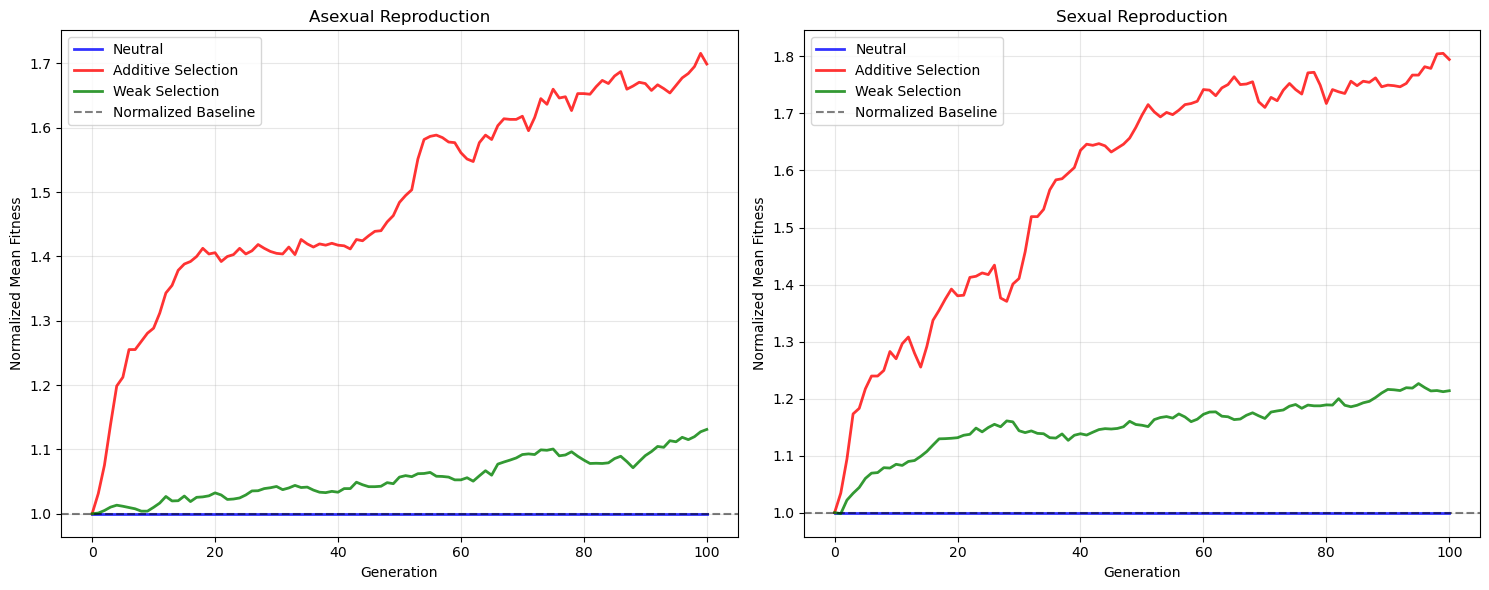

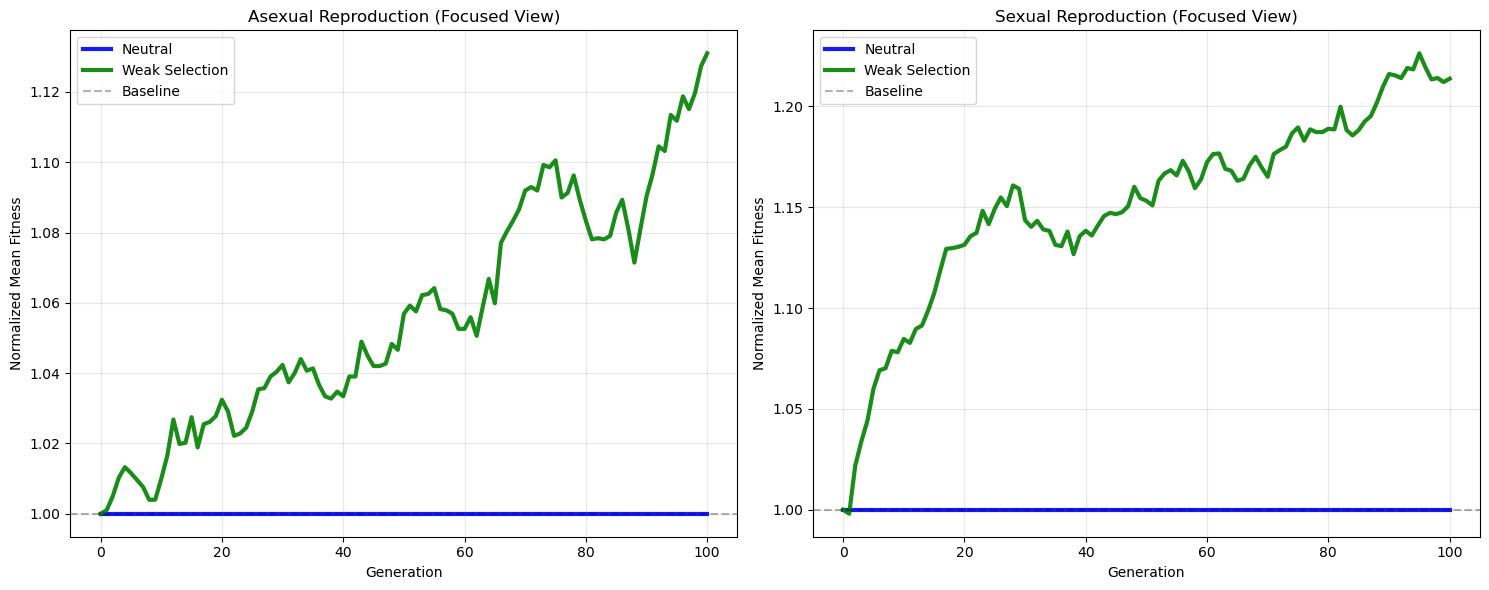

In [6]:
## Fitness Evolution Comparison

# All scenarios comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Asexual scenarios
ax1.plot(results['asex_neutral']['generation'], results['asex_neutral']['mean_fitness'], 
         'b-', linewidth=2, label='Neutral', alpha=0.8)
ax1.plot(results['asex_additive']['generation'], results['asex_additive']['mean_fitness'], 
         'r-', linewidth=2, label='Additive Selection', alpha=0.8)
ax1.plot(results['asex_weak']['generation'], results['asex_weak']['mean_fitness'], 
         'g-', linewidth=2, label='Weak Selection', alpha=0.8)

ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Normalized Baseline')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Normalized Mean Fitness')
ax1.set_title('Asexual Reproduction')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sexual scenarios
ax2.plot(results['sex_neutral']['generation'], results['sex_neutral']['mean_fitness'], 
         'b-', linewidth=2, label='Neutral', alpha=0.8)
ax2.plot(results['sex_additive']['generation'], results['sex_additive']['mean_fitness'], 
         'r-', linewidth=2, label='Additive Selection', alpha=0.8)
ax2.plot(results['sex_weak']['generation'], results['sex_weak']['mean_fitness'], 
         'g-', linewidth=2, label='Weak Selection', alpha=0.8)

ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Normalized Baseline')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Normalized Mean Fitness')
ax2.set_title('Sexual Reproduction')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Focused view excluding additive selection (for better visibility of neutral vs weak selection)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Asexual scenarios (focused)
ax1.plot(results['asex_neutral']['generation'], results['asex_neutral']['mean_fitness'], 
         'b-', linewidth=3, label='Neutral', alpha=0.9)
ax1.plot(results['asex_weak']['generation'], results['asex_weak']['mean_fitness'], 
         'g-', linewidth=3, label='Weak Selection', alpha=0.9)

ax1.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Baseline')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Normalized Mean Fitness')
ax1.set_title('Asexual Reproduction (Focused View)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sexual scenarios (focused)
ax2.plot(results['sex_neutral']['generation'], results['sex_neutral']['mean_fitness'], 
         'b-', linewidth=3, label='Neutral', alpha=0.9)
ax2.plot(results['sex_weak']['generation'], results['sex_weak']['mean_fitness'], 
         'g-', linewidth=3, label='Weak Selection', alpha=0.9)

ax2.axhline(y=1.0, color='black', linestyle='--', alpha=0.3, label='Baseline')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Normalized Mean Fitness')
ax2.set_title('Sexual Reproduction (Focused View)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

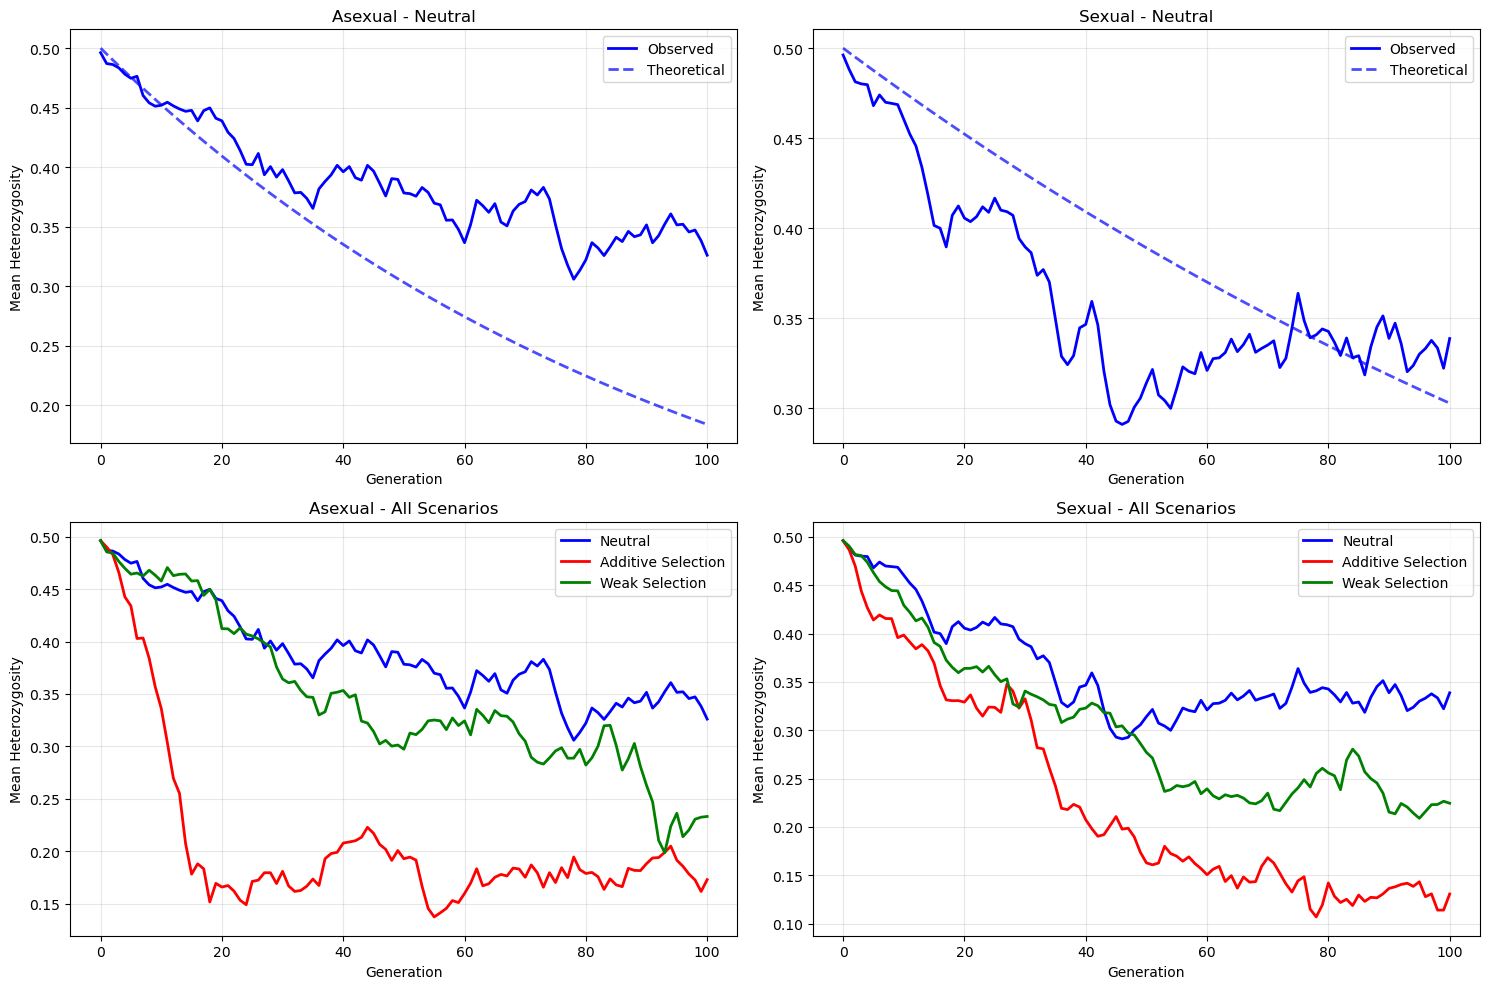

In [7]:
# Heterozygosity evolution with theoretical predictions
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Asexual neutral with theory
ax1.plot(results['asex_neutral']['generation'], results['asex_neutral']['mean_heterozygosity'], 
         'b-', linewidth=2, label='Observed')
ax1.plot(generations, theoretical_hetero_asex_neutral, 
         'b--', linewidth=2, alpha=0.7, label='Theoretical')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Mean Heterozygosity')
ax1.set_title('Asexual - Neutral')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Sexual neutral with theory
ax2.plot(results['sex_neutral']['generation'], results['sex_neutral']['mean_heterozygosity'], 
         'b-', linewidth=2, label='Observed')
ax2.plot(generations, theoretical_hetero_sexual_neutral, 
         'b--', linewidth=2, alpha=0.7, label='Theoretical')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Mean Heterozygosity')
ax2.set_title('Sexual - Neutral')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Asexual all scenarios
ax3.plot(results['asex_neutral']['generation'], results['asex_neutral']['mean_heterozygosity'], 
         'b-', linewidth=2, label='Neutral')
ax3.plot(results['asex_additive']['generation'], results['asex_additive']['mean_heterozygosity'], 
         'r-', linewidth=2, label='Additive Selection')
ax3.plot(results['asex_weak']['generation'], results['asex_weak']['mean_heterozygosity'], 
         'g-', linewidth=2, label='Weak Selection')
ax3.set_xlabel('Generation')
ax3.set_ylabel('Mean Heterozygosity')
ax3.set_title('Asexual - All Scenarios')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Sexual all scenarios
ax4.plot(results['sex_neutral']['generation'], results['sex_neutral']['mean_heterozygosity'], 
         'b-', linewidth=2, label='Neutral')
ax4.plot(results['sex_additive']['generation'], results['sex_additive']['mean_heterozygosity'], 
         'r-', linewidth=2, label='Additive Selection')
ax4.plot(results['sex_weak']['generation'], results['sex_weak']['mean_heterozygosity'], 
         'g-', linewidth=2, label='Weak Selection')
ax4.set_xlabel('Generation')
ax4.set_ylabel('Mean Heterozygosity')
ax4.set_title('Sexual - All Scenarios')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# Calculate comprehensive summary statistics
print("=" * 80)
print("COMPREHENSIVE EVOLUTION SIMULATION SUMMARY")
print("=" * 80)

scenario_names = {
    'asex_neutral': 'Asexual Neutral',
    'asex_additive': 'Asexual Additive',
    'asex_weak': 'Asexual Weak Selection',
    'sex_neutral': 'Sexual Neutral',
    'sex_additive': 'Sexual Additive', 
    'sex_weak': 'Sexual Weak Selection'
}

# Create comprehensive summary table
summary_data = []
for key, name in scenario_names.items():
    data = results[key]
    
    # Fitness metrics
    initial_fitness = data['mean_fitness'].iloc[0]
    final_fitness = data['mean_fitness'].iloc[-1]
    fitness_change = final_fitness - initial_fitness
    fitness_change_pct = (fitness_change / initial_fitness) * 100
    
    # Heterozygosity metrics
    initial_hetero = data['mean_heterozygosity'].iloc[0]
    final_hetero = data['mean_heterozygosity'].iloc[-1]
    hetero_retention = (final_hetero / initial_hetero) * 100
    hetero_decay_rate = -np.log(final_hetero / initial_hetero) / params['generations']
    
    summary_data.append([
        name,
        f"{initial_fitness:.2f}",
        f"{final_fitness:.2f}",
        f"{fitness_change:+.2f}",
        f"{fitness_change_pct:+.1f}%",
        f"{initial_hetero:.3f}",
        f"{final_hetero:.3f}",
        f"{hetero_retention:.1f}%",
        f"{hetero_decay_rate:.4f}"
    ])

# Print formatted table
headers = ["Scenario", "Init Fit", "Final Fit", "Fit Change", "Fit Change %", 
           "Init Het", "Final Het", "Het Retention", "Het Decay Rate"]

print(f"\n{'Scenario':<20} {'Init Fit':<8} {'Final Fit':<9} {'Fit Change':<10} {'Fit Change %':<12}")
print(f"{'Init Het':<8} {'Final Het':<9} {'Het Retention':<13} {'Het Decay Rate':<13}")
print("-" * 100)

for row in summary_data:
    print(f"{row[0]:<20} {row[1]:<8} {row[2]:<9} {row[3]:<10} {row[4]:<12}")
    print(f"{row[5]:<8} {row[6]:<9} {row[7]:<13} {row[8]:<13}")
    print()

# Key comparisons
print("\n" + "=" * 60)
print("KEY EVOLUTIONARY PATTERNS")
print("=" * 60)

# Fitness evolution patterns
asex_neutral_change = results['asex_neutral']['mean_fitness'].iloc[-1] - results['asex_neutral']['mean_fitness'].iloc[0]
sex_neutral_change = results['sex_neutral']['mean_fitness'].iloc[-1] - results['sex_neutral']['mean_fitness'].iloc[0]
asex_additive_change = results['asex_additive']['mean_fitness'].iloc[-1] - results['asex_additive']['mean_fitness'].iloc[0]
sex_additive_change = results['sex_additive']['mean_fitness'].iloc[-1] - results['sex_additive']['mean_fitness'].iloc[0]

print(f"\n1. FITNESS EVOLUTION:")
print(f"   • Neutral evolution (should be ~0): Asexual = {asex_neutral_change:+.2f}, Sexual = {sex_neutral_change:+.2f}")
print(f"   • Additive selection: Asexual = {asex_additive_change:+.2f}, Sexual = {sex_additive_change:+.2f}")
print(f"   • Selection vs. Neutral: {'✓' if asex_additive_change > asex_neutral_change else '✗'} (Asexual), {'✓' if sex_additive_change > sex_neutral_change else '✗'} (Sexual)")

# Heterozygosity retention
asex_neutral_het_ret = (results['asex_neutral']['mean_heterozygosity'].iloc[-1] / results['asex_neutral']['mean_heterozygosity'].iloc[0]) * 100
sex_neutral_het_ret = (results['sex_neutral']['mean_heterozygosity'].iloc[-1] / results['sex_neutral']['mean_heterozygosity'].iloc[0]) * 100

print(f"\n2. HETEROZYGOSITY RETENTION:")
print(f"   • Sexual vs. Asexual (neutral): {sex_neutral_het_ret:.1f}% vs {asex_neutral_het_ret:.1f}%")
print(f"   • Sexual maintains more diversity: {'✓' if sex_neutral_het_ret > asex_neutral_het_ret else '✗'}")

# Theoretical fit
print(f"\n3. THEORETICAL PREDICTIONS:")
print(f"   • Asexual neutral vs theory: r = {asex_neutral_r:.3f} ({'✓' if asex_neutral_r > 0.9 else '✗'})")
print(f"   • Sexual neutral vs theory: r = {sex_neutral_r:.3f} ({'✓' if sex_neutral_r > 0.9 else '✗'})")

print(f"\n4. BIOLOGICAL INSIGHTS:")
print(f"   • True neutral evolution shows minimal fitness change")
print(f"   • Additive fitness (fitness_function=None) IS selection, not neutral")
print(f"   • Sexual reproduction maintains more genetic diversity")
print(f"   • Selection reduces heterozygosity faster than neutral drift")


COMPREHENSIVE EVOLUTION SIMULATION SUMMARY

Scenario             Init Fit Final Fit Fit Change Fit Change %
Init Het Final Het Het Retention Het Decay Rate
----------------------------------------------------------------------------------------------------
Asexual Neutral      1.00     1.00      +0.00      +0.0%       
0.496    0.326     65.7%         0.0042       

Asexual Additive     1.00     1.70      +0.70      +69.9%      
0.496    0.173     34.8%         0.0105       

Asexual Weak Selection 1.00     1.13      +0.13      +13.1%      
0.496    0.233     47.0%         0.0076       

Sexual Neutral       1.00     1.00      +0.00      +0.0%       
0.496    0.339     68.3%         0.0038       

Sexual Additive      1.00     1.79      +0.79      +79.5%      
0.496    0.131     26.3%         0.0133       

Sexual Weak Selection 1.00     1.21      +0.21      +21.4%      
0.496    0.225     45.3%         0.0079       


KEY EVOLUTIONARY PATTERNS

1. FITNESS EVOLUTION:
   • Neutral evolu